In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 2. Unzip the dataset ZIP file (adjust if the path changes)
zip_path = '/content/drive/MyDrive/kvasir-separado.zip'
extract_path = '/content/kvasir_dataset'

!unzip -q "$zip_path" -d "$extract_path"
!ls "$extract_path"

kvasir-separado


In [ ]:
# 3. Install fastai y albumentations
!pip install -q fastai albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.6 MB/s eta 0:00:00


In [ ]:
# 4. Define dataset path
from fastai.vision.all import *
from pathlib import Path
from fastai.metrics import F1Score, Precision, Recall
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

In [ ]:
# 5. Definir ruta del dataset
path = Path('/content/kvasir_dataset/kvasir-separado')

In [ ]:
# 6. Define custom transformation with Albumentations
def get_albumentations_tfms():
    return A.Compose([
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),                  # Enhance local contrast
        A.RandomBrightnessContrast(0.2, 0.2, p=0.5),                            # Global adjustment
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),                               # Blur for robustness
        A.HorizontalFlip(p=0.5),                                                # Flip
        A.Rotate(limit=15, p=0.4),                                              # Slight rotation
        A.Resize(224, 224),                                                     # Final size
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),     # ImageNet normalization
        ToTensorV2()
    ])

In [ ]:
# 7. Create class to use Albumentations with FastAI
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return TensorImage(aug_img)

In [ ]:
# 8. Create DataLoaders with transformations
dls = ImageDataLoaders.from_folder(
    path,
    train='train',
    valid='val',
    item_tfms=Resize(256),  # Resize before cropping
    batch_tfms=[AlbumentationsTransform(get_albumentations_tfms())],
    bs=32
)

print("Clases:", dls.vocab)

Clases: ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


SuggestedLRs(valley=0.0005754399462603033)

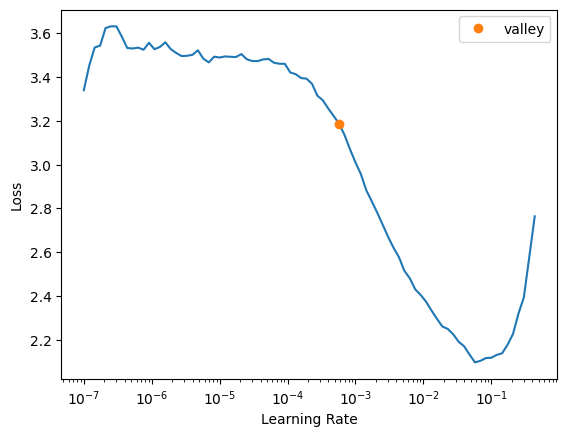

In [ ]:
# 9. Create and compile the Learner with metrics
precision = Precision(average='macro')
recall = Recall(average='macro')
f1 = F1Score(average='macro')

learn = vision_learner(dls, resnet50, metrics=[accuracy, precision, recall, f1])
learn.lr_find()

In [ ]:
from fastai.callback.tracker import SaveModelCallback

# Initial training with 10 epochs
learn.fit_one_cycle(10, 1e-3, cbs=SaveModelCallback(monitor='valid_loss', fname='best_model'))

# Unfreeze the entire model for fine-tuning
learn.unfreeze()

# Training with 20 epochs and save the best model
learn.fit_one_cycle(20, lr_max=slice(1e-6, 1e-4), cbs=SaveModelCallback(monitor='valid_loss', fname='best_model'))

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.955864,0.461070,0.825625,0.826943,0.825625,0.823802,00:23
1,0.624399,0.397493,0.858125,0.862265,0.858125,0.856684,00:22
2,0.480515,0.331798,0.886250,0.887481,0.886250,0.886097,00:22
3,0.375287,0.320607,0.879375,0.887210,0.879375,0.877643,00:22
4,0.323142,0.307047,0.894375,0.897854,0.894375,0.893858,00:22
5,0.244452,0.298521,0.895625,0.900794,0.895625,0.894740,00:22
6,0.209353,0.276541,0.906250,0.907721,0.906250,0.905915,00:22
7,0.197900,0.268124,0.908125,0.908700,0.908125,0.907736,00:22
8,0.162392,0.266369,0.901875,0.903948,0.901875,0.901440,00:22
9,0.155253,0.265357,0.904375,0.905561,0.904375,0.903984,00:22


Better model found at epoch 0 with valid_loss value: 0.4610697627067566.
Better model found at epoch 1 with valid_loss value: 0.3974928557872772.
Better model found at epoch 2 with valid_loss value: 0.3317975699901581.
Better model found at epoch 3 with valid_loss value: 0.3206067681312561.
Better model found at epoch 4 with valid_loss value: 0.3070467710494995.
Better model found at epoch 5 with valid_loss value: 0.2985210716724396.
Better model found at epoch 6 with valid_loss value: 0.2765412926673889.
Better model found at epoch 7 with valid_loss value: 0.2681235373020172.
Better model found at epoch 8 with valid_loss value: 0.26636946201324463.
Better model found at epoch 9 with valid_loss value: 0.26535677909851074.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.175356,0.271017,0.902500,0.903171,0.902500,0.902150,00:23
1,0.158750,0.269820,0.904375,0.906236,0.904375,0.903850,00:23
2,0.165190,0.261847,0.906875,0.909164,0.906875,0.906408,00:23
3,0.144203,0.263655,0.905000,0.906526,0.905000,0.904653,00:22
4,0.131964,0.258139,0.906875,0.910141,0.906875,0.906204,00:23
5,0.113586,0.246738,0.911875,0.912803,0.911875,0.911561,00:23
6,0.117244,0.255576,0.915000,0.917213,0.915000,0.914551,00:23
7,0.097571,0.253261,0.913750,0.913857,0.913750,0.913539,00:23
8,0.080837,0.252154,0.916875,0.919789,0.916875,0.916384,00:23
9,0.071665,0.247941,0.920000,0.920136,0.920000,0.919846,00:23


Better model found at epoch 0 with valid_loss value: 0.27101650834083557.
Better model found at epoch 1 with valid_loss value: 0.26982009410858154.
Better model found at epoch 2 with valid_loss value: 0.26184725761413574.
Better model found at epoch 4 with valid_loss value: 0.25813862681388855.
Better model found at epoch 5 with valid_loss value: 0.24673770368099213.


In [ ]:
# 11. Save model
learn.export('/content/kvasir_v2_resnet50.pkl')

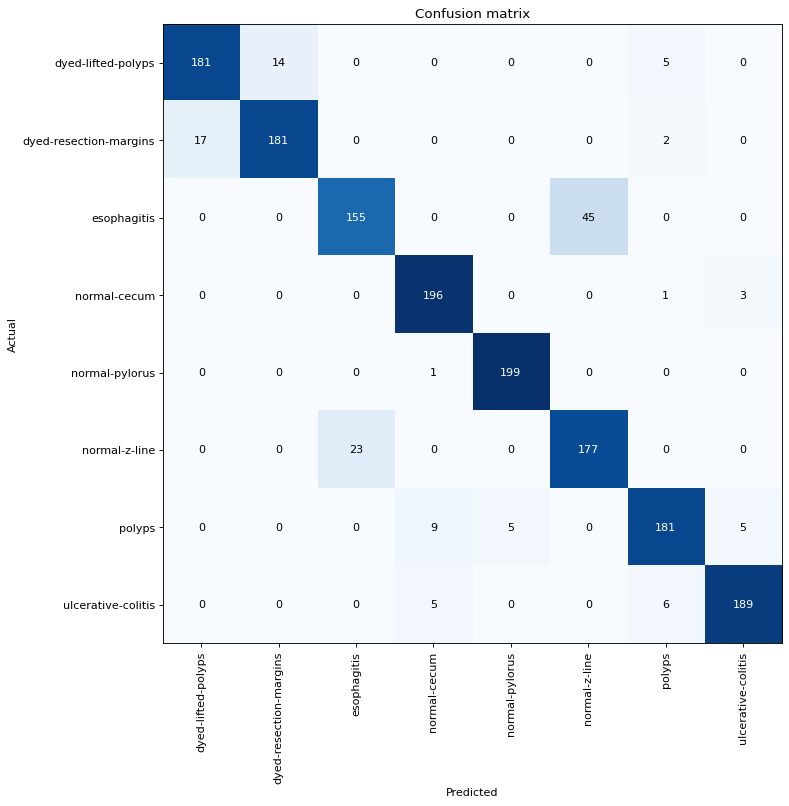

In [ ]:
# 12. Interpretation and analysis
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10), dpi=80)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[('esophagitis', 'normal-z-line', np.int64(45)), ('normal-z-line', 'esophagitis', np.int64(23)), ('dyed-resection-margins', 'dyed-lifted-polyps', np.int64(17)), ('dyed-lifted-polyps', 'dyed-resection-margins', np.int64(14)), ('polyps', 'normal-cecum', np.int64(9)), ('ulcerative-colitis', 'polyps', np.int64(6)), ('dyed-lifted-polyps', 'polyps', np.int64(5)), ('polyps', 'normal-pylorus', np.int64(5)), ('polyps', 'ulcerative-colitis', np.int64(5)), ('ulcerative-colitis', 'normal-cecum', np.int64(5)), ('normal-cecum', 'ulcerative-colitis', np.int64(3))]


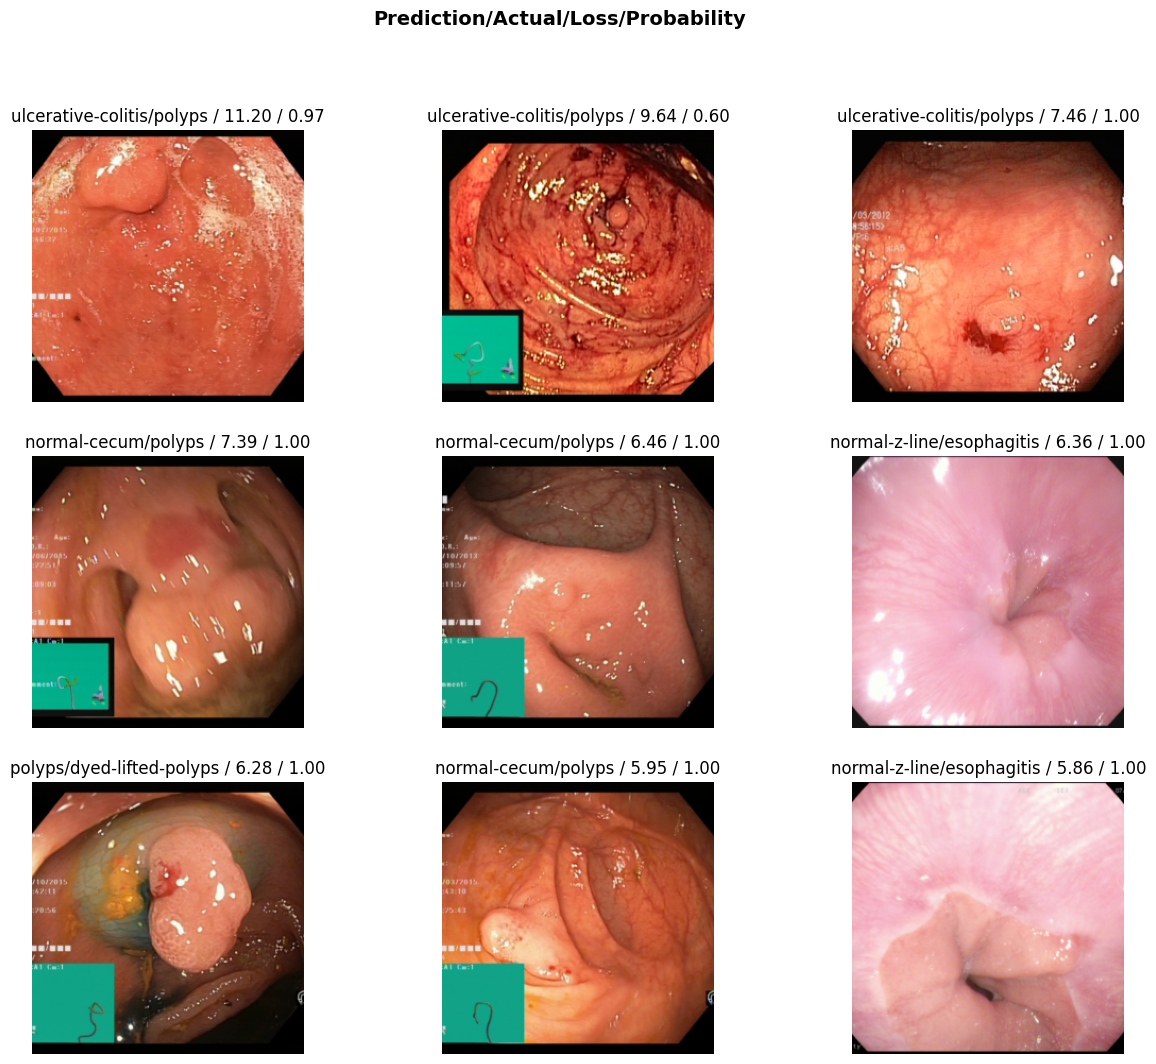

In [ ]:
interp.plot_top_losses(9, figsize=(15,12))
print(interp.most_confused(min_val=3))

In [ ]:
# 13. Final Macro F1
preds, targs = learn.get_preds(ds_idx=1)
pred_labels = preds.argmax(dim=1)
from sklearn.metrics import f1_score
f1_macro = f1_score(targs, pred_labels, average='macro')
print(f"F1 macro final en validación: {f1_macro:.4f}")

F1 macro final en validación: 0.9116


In [ ]:
# 14. Calculation of detailed metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, multilabel_confusion_matrix
import pandas as pd
import numpy as np

preds, targs = learn.get_preds()
pred_labels = preds.argmax(dim=1).numpy()
true_labels = targs.numpy()
classes = dls.vocab

precision = precision_score(true_labels, pred_labels, average=None, zero_division=0)
recall = recall_score(true_labels, pred_labels, average=None, zero_division=0)
f1 = f1_score(true_labels, pred_labels, average=None, zero_division=0)
accuracy = accuracy_score(true_labels, pred_labels)

mcm = multilabel_confusion_matrix(true_labels, pred_labels)

metrics = []
for i, cls in enumerate(classes):
    tn, fp, fn, tp = mcm[i].ravel()
    metrics.append({
        'class': cls,
        'precision': precision[i],
        'recall': recall[i],
        'f1_score': f1[i],
        'accuracy': accuracy,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn
    })

df = pd.DataFrame(metrics)
csv_path = 'Kvasir_fastai_metrics.csv'
df.to_csv(csv_path, index=False)
print(f"✅ Métricas guardadas en: {csv_path}")

✅ Métricas guardadas en: Kvasir_fastai_metrics.csv


In [ ]:
# 15. Show table
df[['precision', 'recall', 'f1_score', 'accuracy']] = df[['precision', 'recall', 'f1_score', 'accuracy']].round(4)
from tabulate import tabulate
print("\nMétricas por clase:\n")
print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))

NameError: name 'df' is not defined